#### Calculate a reasonable LST value for every surface classification in ERA5 Dataset



In [1]:
#
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable

import sys

sys.path.append("../../")

from src.processing import windsat_datacube

# Files
ws_path = "../../data/raw/daily_windsat/"
igbp_path = "../../data/processed/regridded.h5"

# Toggle temperatue in celsius instead of kelvin

in_celsius = True

### Get the IGBP Classification
Resampled from https://lpdaac.usgs.gov/products/mcd12c1v006/ using the notebook IGBP_lancover.ipynb

In [2]:
# I thought maybe it will be nice to have the temperatures in ºC, since the freezing point is interesting to have
def kelvin2celsius(t: float) -> float:
    return t - 273.15

In [3]:
igbp_ds = xr.open_dataset(igbp_path)
igbp_ds

<xarray.Dataset> Size: 4MB
Dimensions:      (y: 720, x: 1440)
Coordinates:
  * y            (y) float32 3kB -89.88 -89.62 -89.38 ... 89.38 89.62 89.88
  * x            (x) float32 6kB 0.125 0.375 0.625 0.875 ... 359.4 359.6 359.9
Data variables:
    spatial_ref  int32 4B ...
    IGBP         (y, x) float32 4MB ...
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [4]:
# I dont like any of default colormaps, lets create our own:
custon_cmap = {
    'water': '#0000AA',
    'evergreen needleleaf forest': '#006400',
    'evergreen broadleaf forest': '#228B22',
    'deciduous needleleaf forest': '#32CD32',
    'deciduous broadleaf forest': '#7CFC00',
    'mixed forests': '#8FBC8F',
    'closed shrubland': '#8B4513',
    'open shrublands': '#DEB887',
    'woody savannas': '#D2691E',
    'savannas': '#FFA500',
    'grasslands': '#7FAA00',
    'permanent wetlands': '#00FFFF',
    'croplands': '#FFD700',
    'urban and built-up': '#A9A9A9',
    'cropland/natural vegetation mosaic': '#808000',
    'snow and ice': '#AAAAFF',
    'barren or sparsely vegetated': '#F5F5DC',
}
cmap = mcolors.ListedColormap(list(custon_cmap.values()), name='land_cover')

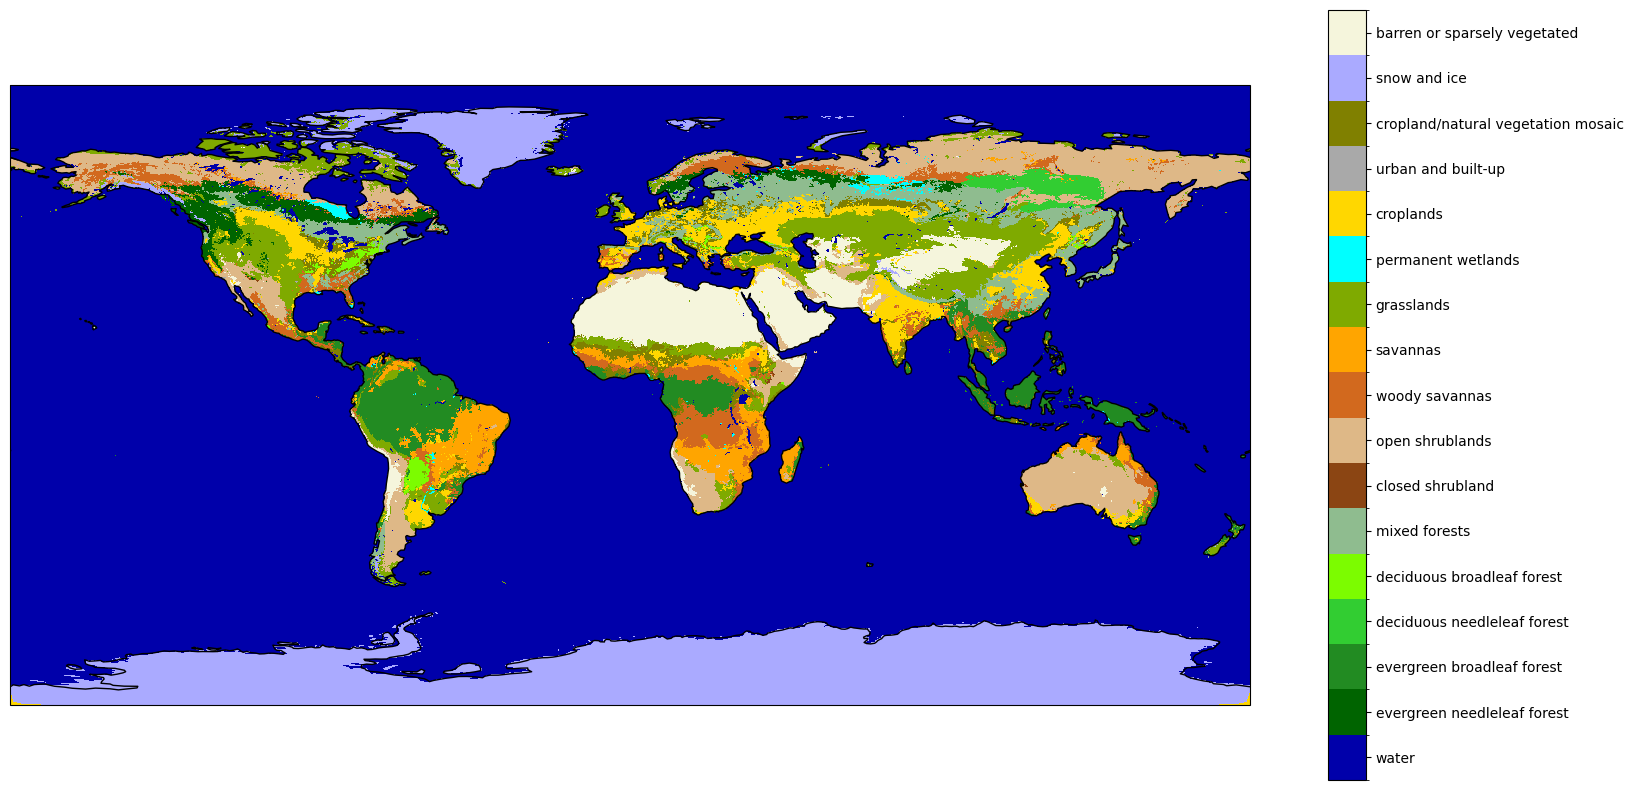

In [5]:
# Visualization of the surface classes 
fig, ax = plt.subplots(1,1,figsize = (20,10), subplot_kw = {"projection" : ccrs.PlateCarree(central_longitude=0)})

igbp_ds.roll(
    {
        "x" : 180 * 4
    }
).IGBP.plot(ax= ax, cmap = cmap, add_colorbar = False)

ax.coastlines("110m")

# Create a normalization object
norm = mcolors.BoundaryNorm(np.arange(len(custon_cmap) + 1) - 0.5, len(custon_cmap))

# Create colorbar with custom ticks and labels
cbar = plt.colorbar(ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', pad=0.05)
cbar.set_ticks(np.arange(len(custon_cmap)))
cbar.set_ticklabels(list(custon_cmap.keys()))

# Show the plot
plt.show()

In [63]:
igbp_ds.IGBP.attrs

{'long_name': 'Majority_Land_Cover_Type_1',
 'units': 'class number',
 'valid_range': array([ 0, 16], dtype=uint8),
 'water': 0,
 'evergreen needleleaf forest': 1,
 'evergreen broadleaf forest': 2,
 'deciduous needleleaf forest': 3,
 'deciduous broadleaf forest': 4,
 'mixed forests': 5,
 'closed shrubland': 6,
 'open shrublands': 7,
 'woody savannas': 8,
 'savannas': 9,
 'grasslands': 10,
 'permanent wetlands': 11,
 'croplands': 12,
 'urban and built-up': 13,
 'cropland/natural vegetation mosaic': 14,
 'snow and ice': 15,
 'barren or sparsely vegetated': 16,
 'unclassified': 255,
 'grid_mapping': 'spatial_ref'}

In [64]:
# Save this dic for converting class ID into name 
name2id = {
 'water': 0,
 'evergreen needleleaf forest': 1,
 'evergreen broadleaf forest': 2,
 'deciduous needleleaf forest': 3,
 'deciduous broadleaf forest': 4,
 'mixed forests': 5,
 'closed shrubland': 6,
 'open shrublands': 7,
 'woody savannas': 8,
 'savannas': 9,
 'grasslands': 10,
 'permanent wetlands': 11,
 'croplands': 12,
 'urban and built-up': 13,
 'cropland/natural vegetation mosaic': 14,
 'snow and ice': 15,
 'barren or sparsely vegetated': 16,
 }

# we actually need the keys and the items swapped
id2name = {v:k for k,v in name2id.items()}

In [65]:
# Load windsat dataset
ws_ds = windsat_datacube(ws_path)
ws_ds

<xarray.Dataset> Size: 3GB
Dimensions:         (day_number: 24, longitude_grid: 1440, latitude_grid: 720,
                     swath_sector: 2, frequency_band: 2, polarization: 2)
Coordinates:
    lat             (latitude_grid) float32 3kB dask.array<chunksize=(720,), meta=np.ndarray>
    lon             (longitude_grid) float32 6kB dask.array<chunksize=(1440,), meta=np.ndarray>
  * day_number      (day_number) int32 96B 1 2 57 58 84 ... 283 323 324 348 349
Dimensions without coordinates: longitude_grid, latitude_grid, swath_sector,
                                frequency_band, polarization
Data variables: (12/13)
    longitude       (day_number, longitude_grid) float32 138kB dask.array<chunksize=(1, 1440), meta=np.ndarray>
    latitude        (day_number, latitude_grid) float32 69kB dask.array<chunksize=(1, 720), meta=np.ndarray>
    node            (day_number, swath_sector) int32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_vpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    frequency_hpol  (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    eia_nominal     (day_number, frequency_band) float32 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    ...              ...
    eaa             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 398MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    eia             (day_number, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 398MB dask.array<chunksize=(1, 1, 360, 720, 1), meta=np.ndarray>
    tbtoa           (day_number, polarization, frequency_band, latitude_grid, longitude_grid, swath_sector) float32 796MB dask.array<chunksize=(1, 1, 1, 240, 480, 1), meta=np.ndarray>
    quality_flag    (day_number, latitude_grid, longitude_grid, swath_sector) int32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    surtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
    airtep_ERA5     (day_number, latitude_grid, longitude_grid, swath_sector) float32 199MB dask.array<chunksize=(1, 360, 720, 1), meta=np.ndarray>
Attributes: (12/72)
    Conventions:                            CF-1.7
    title:                                  RSS WindSat TOA Brightness Temper...
    version:                                V01.0
    summary:                                The dataset contains RSS WindSat ...
    references:                              [1] T. Meissner et al., Remote S...
    acknowledgement:                        Funded under NASA Grant 80NSSC21K...
    ...                                     ...
    Source_of_ancillary_IMERG_rain_rate:    Huffman, G. et al.,  2019. NASA G...
    Source_of_ancillary_CCMP_wind:          Mears, C. et al., 2023.Remote Sen...
    Source_of_ancillary_ERA5:               ECMWF Reanalysis v5 (ERA5). https...
    Source_of_RSS_WindSat_AS_ECV:           https://www.remss.com/missions/wi...
    Source_of_ancillary_HYCOM_SSS:          Hybrid Coordinate Ocean Model, Gl...
    Source_of_WindSat_L1C_TB:               T. Meissner et al., Remote Sensin...

In [66]:
# Add surface class to ws dataset
ws_ds["IGBP"] = (("latitude_grid","longitude_grid"), igbp_ds.IGBP.values)

In [67]:
sclass_mean = {}
untis = "K"
for i in range(0,17,1):
    sub_ds = ws_ds.where(ws_ds["IGBP"] == i)
    mean_lst = sub_ds.surtep_ERA5.mean()
    sclass_mean[i] = mean_lst.values

    if in_celsius:
        sclass_mean[i] = kelvin2celsius(sclass_mean[i])
        untis = "ºC"

data = [(id2name[k], sclass_mean[k]) for k in sclass_mean.keys()]

df = pd.DataFrame(data, columns=["IGBP Class", f"Mean ERA5 skin temperature [{untis}]"])
df

,IGBP Class,Mean ERA5 skin temperature [ºC]
0,water,6.429742
1,evergreen needleleaf forest,1.605127
2,evergreen broadleaf forest,22.484827
3,deciduous needleleaf forest,-4.705176
4,deciduous broadleaf forest,16.743311
5,mixed forests,4.649286
6,closed shrubland,21.444299
7,open shrublands,-1.258612
8,woody savannas,8.616876
9,savannas,20.647363


# histograms

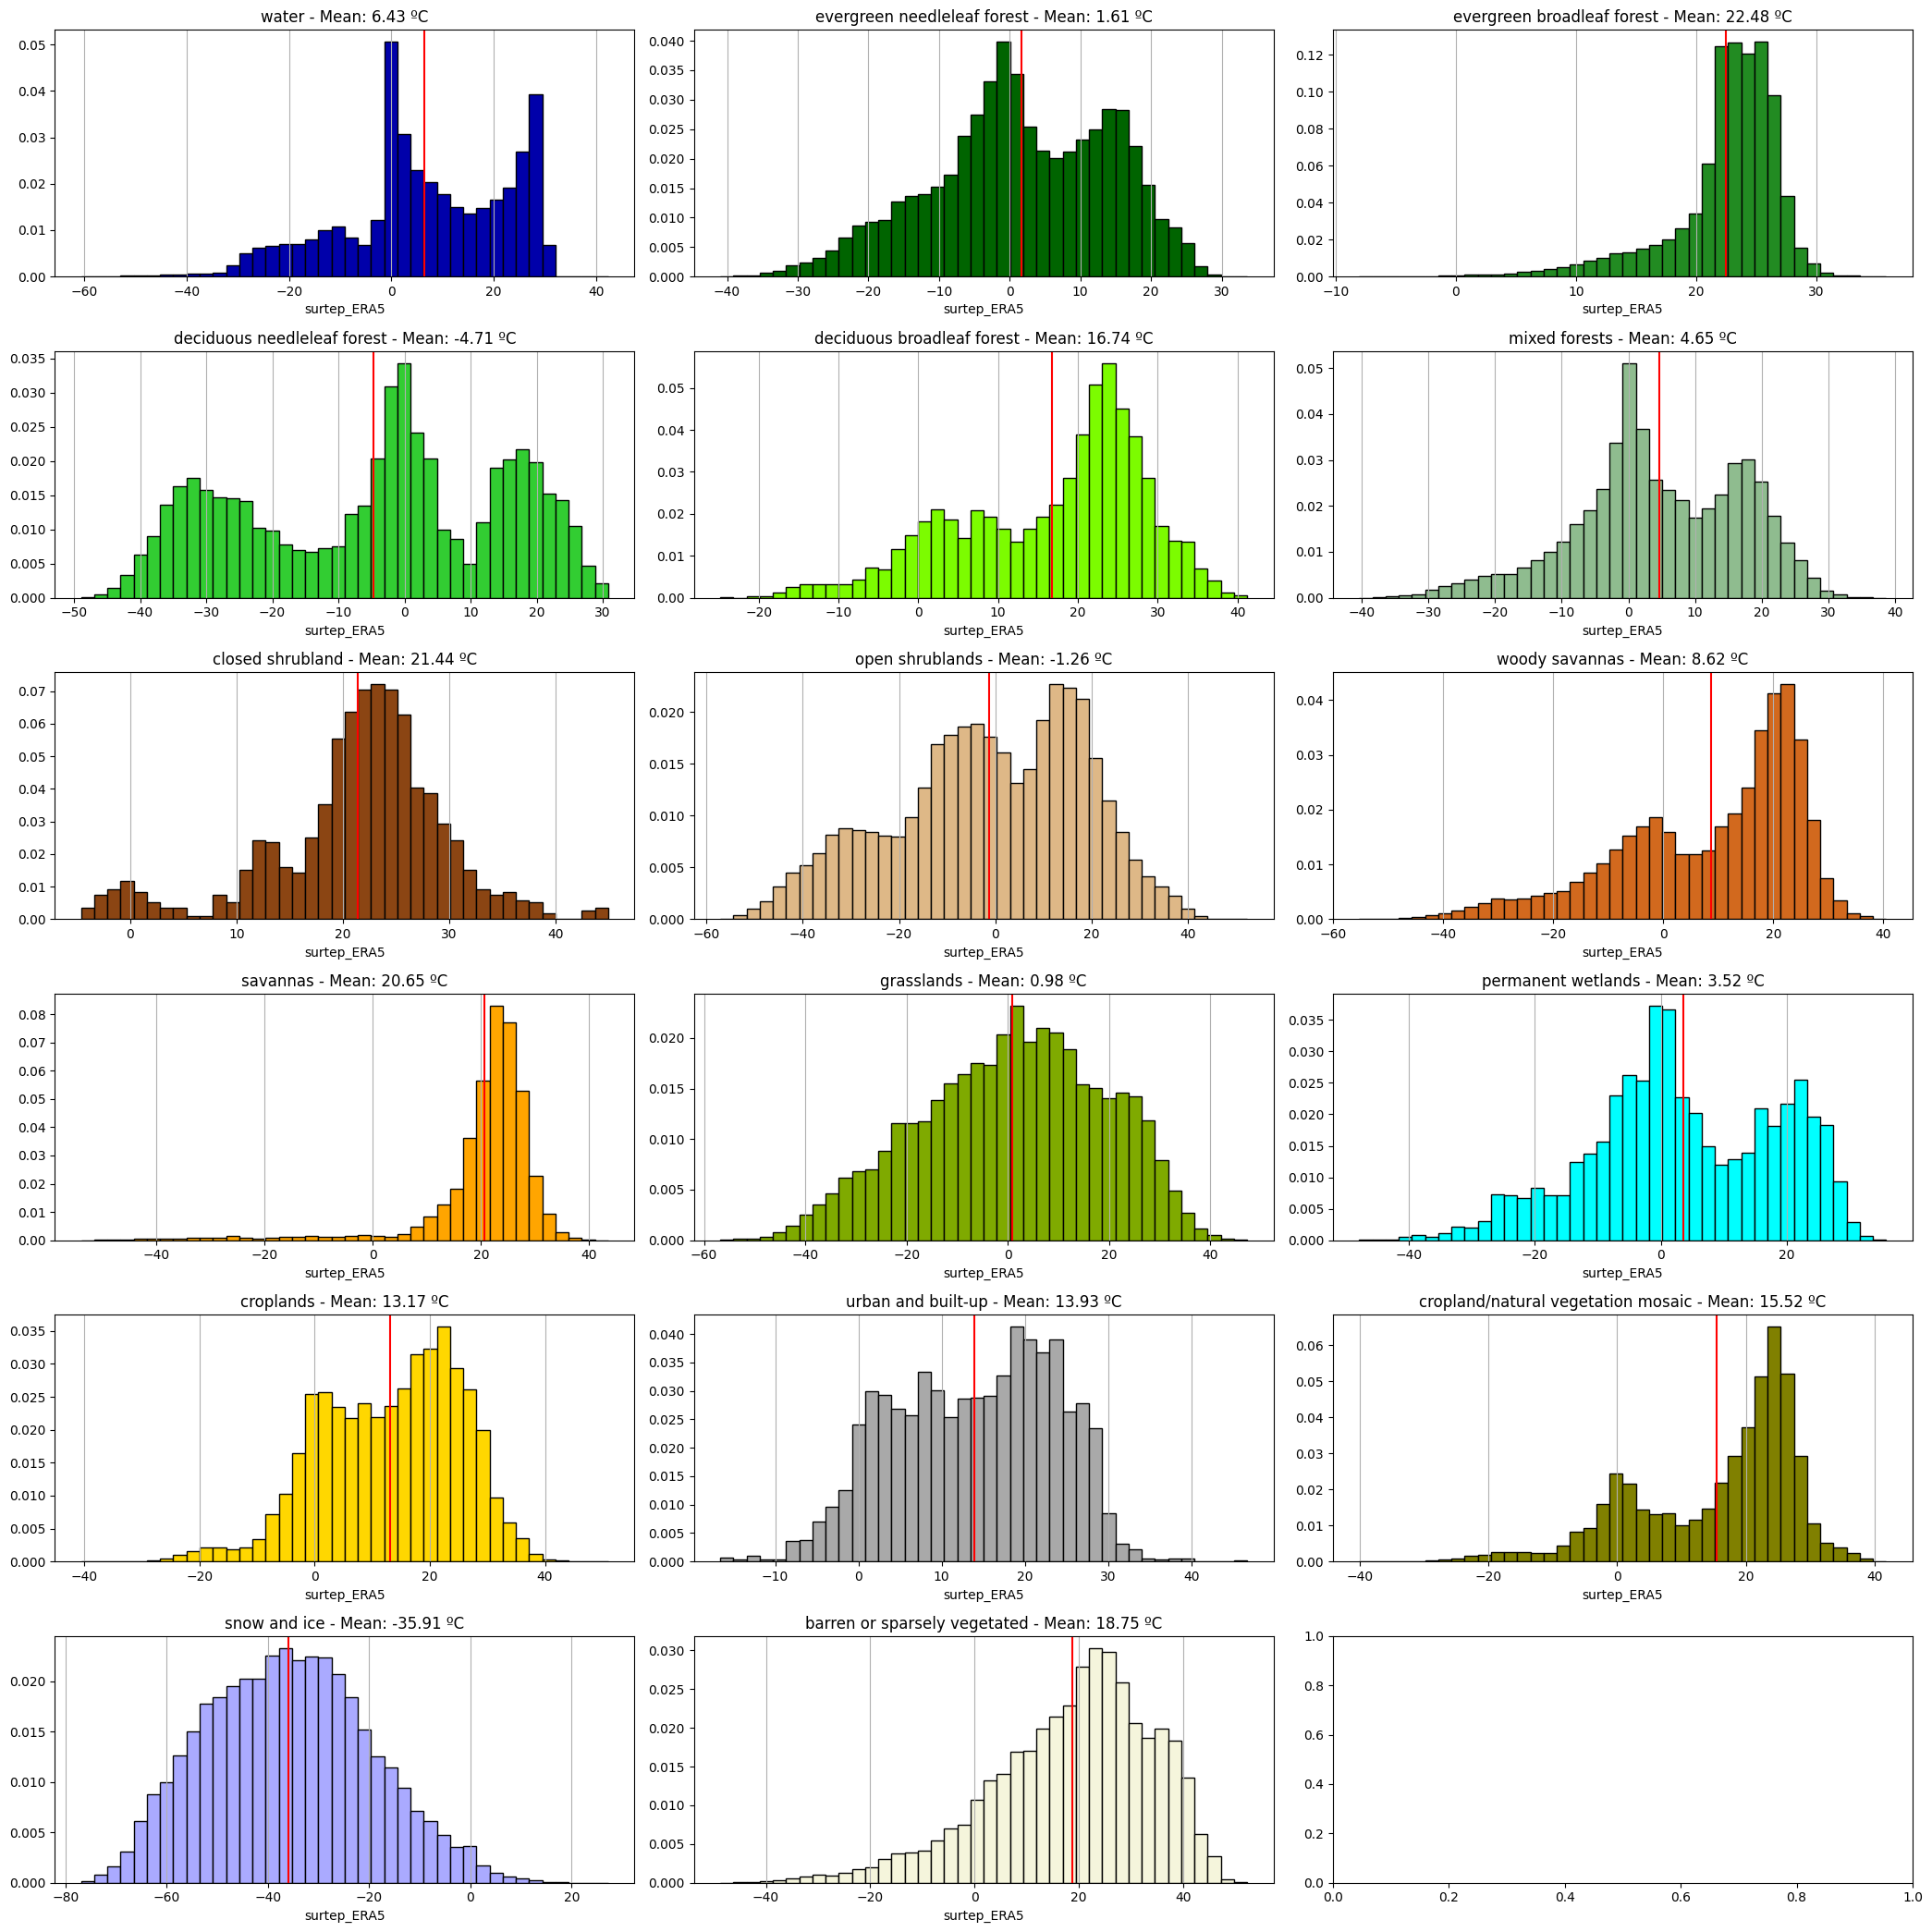

In [68]:
# Create histograms for each land class, not only the mean value
fig, axs = plt.subplots(6,3, figsize = (21,21))

for i in range(0,17,1):
    nrow, ncol = i // 3, i % 3
    ax = axs[nrow, ncol]

    title = f"{id2name[i]} - Mean: {sclass_mean[i]:.2f} K"
    color =  custon_cmap[id2name[i]]

    sub_ds = ws_ds.where(ws_ds["IGBP"] == i)
    to_plot = sub_ds.surtep_ERA5

    if in_celsius:
        to_plot = xr.apply_ufunc(kelvin2celsius, sub_ds.surtep_ERA5, dask="parallelized", output_dtypes= [float])
        title = f"{id2name[i]} - Mean: {sclass_mean[i]:.2f} ºC"

    to_plot.plot.hist(
        ax=ax, density = True, label = id2name[i],
        bins = 40, color = color, edgecolor = "black"
    )
    # Add the mean as a line
    ax.axvline(x = sclass_mean[i], color = "red")
    ax.grid(axis = "x")
    ax.set_title(title)


fig.tight_layout()


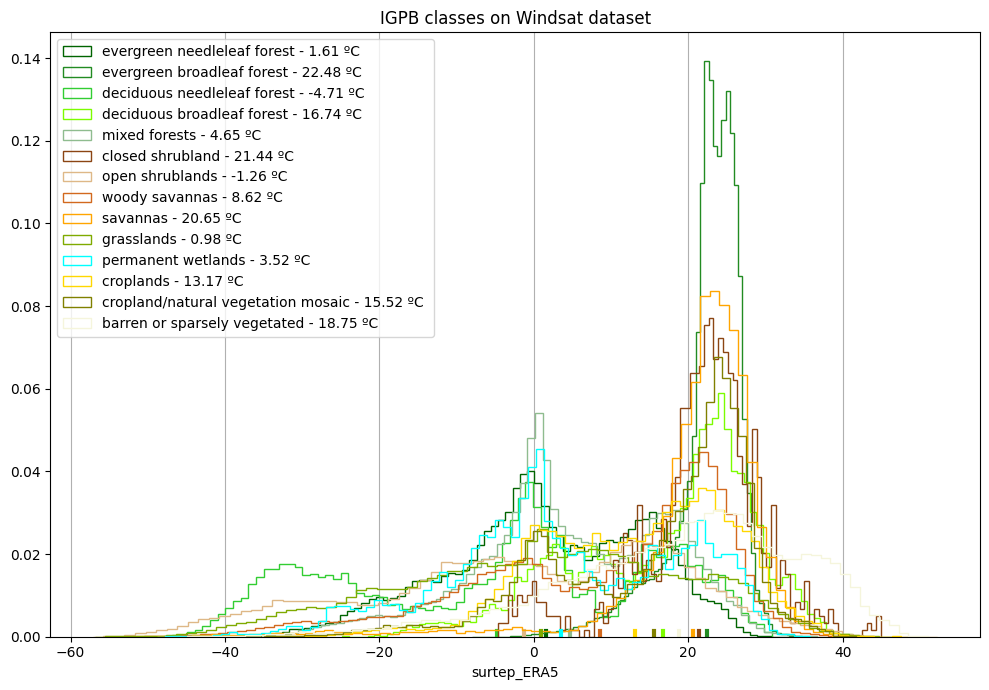

In [69]:
# Combined histogram:
fig, ax = plt.subplots(1,1, figsize = (10,7))

dummy_classes = [
    "water",
    "urban and built-up",
    "snow and ice",
]
for i in range(17):

    if id2name[i] in dummy_classes:
        continue

    sub_ds = ws_ds.where(ws_ds["IGBP"] == i)
    label = f"{id2name[i]} - {sclass_mean[i]:.2f} K "

    to_plot = sub_ds.surtep_ERA5

    color =  custon_cmap[id2name[i]]

    if in_celsius:
        to_plot = xr.apply_ufunc(kelvin2celsius, sub_ds.surtep_ERA5, dask="parallelized", output_dtypes= [float])
        label = f"{id2name[i]} - {sclass_mean[i]:.2f} ºC "

    to_plot.plot.hist(
        ax=ax, density = True, label = label,
        bins = 80, alpha = 1, histtype = "step", color =color,
        edgecolor = color
    )
    ax.axvline(x = sclass_mean[i], color = color, alpha = 1, ymax= 0.01, ymin= -0.01, linewidth = 3 )

ax.grid(axis = "x")
ax.legend(loc = "upper left")
ax.set_title("IGPB classes on Windsat dataset")
fig.tight_layout()

# TODO
It will be nice for this to be an interactive histogram, where we can togle on and off different surface classes ... for now lets leave it as it is.